# Advanced Parquet Analysis Queries

This notebook demonstrates advanced queries for analyzing the Parquet files using DuckDB.

In [24]:
!pip install seaborn ace_tools pyarrow
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization settings
plt.style.use('bmh')
sns.set_theme()
pd.set_option('display.max_columns', None)

# Initialize DuckDB with optimized settings
conn = duckdb.connect(database=':memory:', read_only=False)
conn.execute("SET memory_limit='28GB'")
conn.execute("PRAGMA threads=32")

print("✅ DuckDB configured for analysis")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 113.7 MB/s eta 0:00:00 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
✅ DuckDB configured for analysis


## 1. Cover URL Analysis

Analyzing cover URL patterns and sources:

In [65]:
cover_query = """
WITH cover_sources AS (
 SELECT 
 CASE
 WHEN _source_file_unified_data_cover_url_best LIKE '%archive.org%' THEN 'Internet Archive'
 WHEN _source_file_unified_data_cover_url_best LIKE '%openlibrary.org%' THEN 'Open Library'
 WHEN _source_file_unified_data_cover_url_best LIKE '%isbndb.com%' THEN 'ISBNdb'
 ELSE 'Other'
 END as cover_source,
 COUNT(*) as count
 FROM read_parquet('/data/elasticsearchF/*.parquet')
 WHERE _source_file_unified_data_cover_url_best IS NOT NULL
 GROUP BY cover_source
)
SELECT * FROM cover_sources
ORDER BY count DESC;
"""

df_covers = conn.execute(cover_query).fetchdf()
display(df_covers)

,cover_source,count
0,Other,35964195
1,Internet Archive,10138212
2,Open Library,919163
3,ISBNdb,837974


## 2. File name search

Search by file name

In [2]:
filenamesearch_query = """
SELECT
    _source_file_unified_data_original_filename_best as filename,
    _source_file_unified_data_title_best as title,
    _source_file_unified_data_author_best as author,
    _source_file_unified_data_publisher_best as publisher,
    _source_file_unified_data_year_best as year,
    _source_file_unified_data_filesize_best as filesize,
    _source_file_unified_data_extension_best as extension,
    _source_file_unified_data_cover_url_best as cover_url
FROM read_parquet('/data/elasticsearchF/*.parquet')
WHERE _source_file_unified_data_original_filename_best LIKE '%chumashindiansof0000euge.pdf%'
LIMIT 10;
"""

df_search = conn.execute(filenamesearch_query).fetchdf()
display(df_search)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,filename,title,author,publisher,year,filesize,extension,cover_url
0,ia/chumashindiansof0000euge.pdf,The Chumash Indians of Southern California,Eugene Newton Anderson,Malki Museum Press,1968,2402005,pdf,https://archive.org/download/chumashindiansof0...


## 3. MD5 Search

Search by md5

In [3]:
filenamesearch_query = """
SELECT
    _id as id,
    _source_file_unified_data_original_filename_best as filename,
    _source_file_unified_data_title_best as title,
    _source_file_unified_data_author_best as author,
    _source_file_unified_data_publisher_best as publisher,
    _source_file_unified_data_year_best as year,
    _source_file_unified_data_filesize_best as filesize,
    _source_file_unified_data_extension_best as extension,
    _source_file_unified_data_cover_url_best as cover_url
FROM read_parquet('/data/elasticsearchF/*.parquet')
WHERE _id = 'md5:28733ed435e61b5ededce1f64096be33'
LIMIT 10;
"""

df_search = conn.execute(filenamesearch_query).fetchdf()
display(df_search)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,id,filename,title,author,publisher,year,filesize,extension,cover_url
0,md5:28733ed435e61b5ededce1f64096be33,ia/chumashindiansof0000euge.pdf,The Chumash Indians of Southern California,Eugene Newton Anderson,Malki Museum Press,1968,2402005,pdf,https://archive.org/download/chumashindiansof0...


## 4. File Size Distribution by Content Type

Analyzing file sizes across different content types:

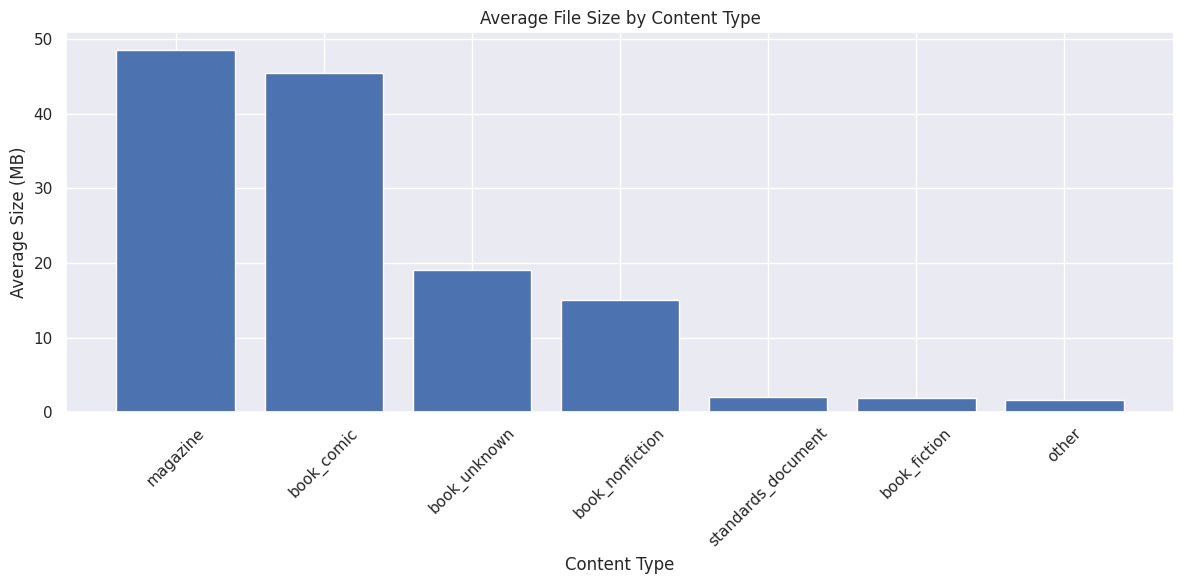

In [4]:
filesize_query = """
WITH size_stats AS (
 SELECT
 _source_file_unified_data_content_type_best as content_type,
 TRY_CAST(_source_file_unified_data_filesize_best AS FLOAT) / (1024*1024) as size_mb
 FROM read_parquet('/data/elasticsearchF/*.parquet')
 WHERE _source_file_unified_data_filesize_best IS NOT NULL
)
SELECT
 content_type,
 COUNT(*) as count,
 ROUND(AVG(size_mb), 2) as avg_size_mb,
 ROUND(MIN(size_mb), 2) as min_size_mb,
 ROUND(MAX(size_mb), 2) as max_size_mb
FROM size_stats
GROUP BY content_type
HAVING count > 1000
ORDER BY avg_size_mb DESC;
"""

df_filesizes = conn.execute(filesize_query).fetchdf()

plt.figure(figsize=(12, 6))
plt.bar(df_filesizes['content_type'], df_filesizes['avg_size_mb'])
plt.title('Average File Size by Content Type')
plt.xlabel('Content Type')
plt.ylabel('Average Size (MB)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Classification Analysis

Analyzing the unified classifications:

In [5]:
classification_query = """
WITH classifications AS (
 SELECT 
 json_extract_string(_source_file_unified_data_classifications_unified, '$.ia_collection[0]') as collection,
 json_extract_string(_source_file_unified_data_classifications_unified, '$.oclc_holdings[0]') as holdings,
 json_extract_string(_source_file_unified_data_classifications_unified, '$.content_type[0]') as content_type
 FROM read_parquet('/data/elasticsearchF/*.parquet')
)
SELECT 
 collection,
 holdings,
 content_type,
 COUNT(*) as count
FROM classifications
WHERE collection IS NOT NULL
GROUP BY collection, holdings, content_type
HAVING count > 100
ORDER BY count DESC;
"""

df_classifications = conn.execute(classification_query).fetchdf()
display(df_classifications)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,collection,holdings,content_type,count
0,printdisabled,None,book_unknown,1637776
1,internetarchivebooks,None,book_unknown,1504518
2,printdisabled,many,book_unknown,770799
3,internetarchivebooks,many,book_unknown,765063
4,inlibrary,None,book_unknown,624241
...,...,...,...,...
1676,pub_explicator,None,magazine,101
1677,pub_cable-television-business,None,magazine,101
1678,pub_philadelphia-magazine,None,magazine,101
1679,pub_infection-and-immunity,None,magazine,101


## 6. Search Access Types Analysis

Analyzing the distribution of access types:

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

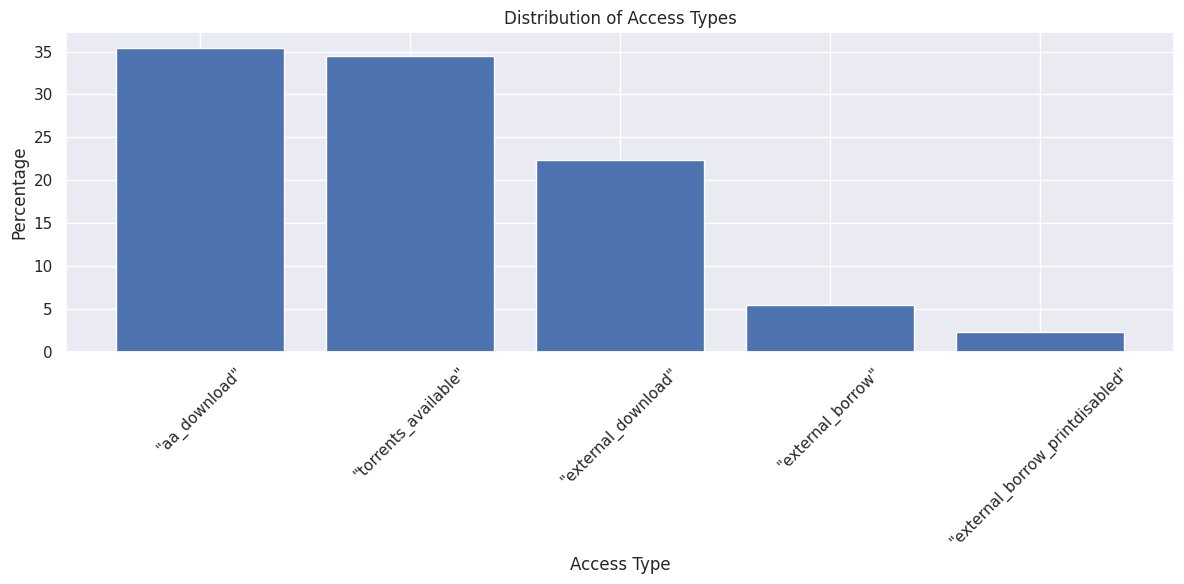

In [7]:
access_query = """
WITH access_types AS (
    SELECT 
        unnest(_source_search_only_fields_search_access_types::VARCHAR[]) AS access_type
    FROM read_parquet('/data/elasticsearchF/*.parquet')
)
SELECT 
    access_type,
    COUNT(*) AS count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) AS percentage
FROM access_types
GROUP BY access_type
ORDER BY count DESC;
"""

df_access = conn.execute(access_query).fetchdf()

plt.figure(figsize=(12, 6))
plt.bar(df_access['access_type'], df_access['percentage'])
plt.title('Distribution of Access Types')
plt.xlabel('Access Type')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Score Analysis

Analyzing base rank scores:

In [8]:
score_query = """
WITH score_stats AS (
 SELECT
 _source_search_only_fields_search_score_base_rank as base_rank,
 _source_file_unified_data_content_type_best as content_type
 FROM read_parquet('/data/elasticsearchF/*.parquet')
 WHERE _source_search_only_fields_search_score_base_rank IS NOT NULL
)
SELECT
 content_type,
 COUNT(*) as count,
 ROUND(AVG(CAST(base_rank AS FLOAT)), 2) as avg_rank,
 MIN(CAST(base_rank AS FLOAT)) as min_rank,
 MAX(CAST(base_rank AS FLOAT)) as max_rank
FROM score_stats
GROUP BY content_type
HAVING count > 100
ORDER BY avg_rank DESC;
"""

df_scores = conn.execute(score_query).fetchdf()
display(df_scores)

,content_type,count,avg_rank,min_rank,max_rank
0,magazine,4535434,10877.16,0.01,10998.0
1,musical_score,489,10824.71,9859.00,13898.0
2,book_unknown,23584279,10820.15,0.01,14068.0
3,book_fiction,9311848,10729.10,0.01,14068.0
4,standards_document,999168,10691.36,0.01,10995.0
5,other,69633,10679.42,9853.00,10995.0
6,book_nonfiction,6634241,10597.41,0.01,14068.0
7,book_comic,2724452,9261.71,0.01,13985.0


## 8. Title Length Analysis

Analyzing the distribution of title lengths:

In [9]:
title_length_query = """
WITH title_stats AS (
 SELECT
 LENGTH(_source_file_unified_data_title_best) as title_length,
 _source_file_unified_data_content_type_best as content_type
 FROM read_parquet('/data/elasticsearchF/*.parquet')
 WHERE _source_file_unified_data_title_best IS NOT NULL
)
SELECT
 content_type,
 COUNT(*) as count,
 ROUND(AVG(title_length), 2) as avg_length,
 MIN(title_length) as min_length,
 MAX(title_length) as max_length
FROM title_stats
GROUP BY content_type
HAVING count > 100
ORDER BY avg_length DESC;
"""

df_titles = conn.execute(title_length_query).fetchdf()
display(df_titles)

,content_type,count,avg_length,min_length,max_length
0,standards_document,999168,78.22,0,1195
1,book_nonfiction,6634241,60.78,0,3323
2,other,69633,55.96,0,1372
3,magazine,4535434,35.91,0,257
4,book_unknown,23584279,29.75,0,30000
5,book_fiction,9311848,28.15,0,2019
6,musical_score,489,7.29,0,102
7,book_comic,2724452,3.60,0,268


## 9. Distribution of Publication Years

Analyzing Publication Years:

<Axes: title={'center': 'Distribution of Publication Years'}, xlabel='publish_year'>

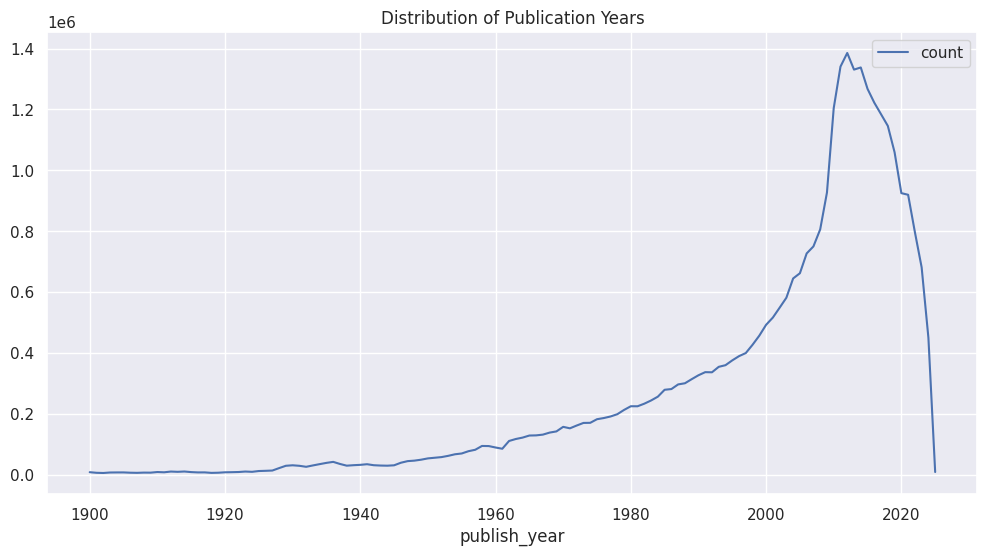

In [10]:
pub_year_query = """
SELECT
    TRY_CAST(_source_search_only_fields_search_year AS INTEGER) AS publish_year,
    COUNT(*) AS count
FROM read_parquet('/data/elasticsearchF/*.parquet')
WHERE publish_year IS NOT NULL
GROUP BY publish_year
HAVING publish_year BETWEEN 1900 AND 2025
ORDER BY publish_year;
"""

df_pub_year = conn.execute(pub_year_query).fetchdf()
df_pub_year.plot(x='publish_year', y='count', kind='line', figsize=(12, 6), title="Distribution of Publication Years")


## 10. Author Name Search

Search all books by an Author:

In [11]:
author_name = "Eugene Newton Anderson"

author_books_query = f"""
SELECT
    _source_file_unified_data_title_best AS title,
    _source_file_unified_data_author_best AS author,
    _source_file_unified_data_publisher_best AS publisher,
    TRY_CAST(_source_file_unified_data_year_best AS INTEGER) AS publish_year,
    _source_file_unified_data_cover_url_best AS cover_url
FROM read_parquet('/data/elasticsearchF/*.parquet')
WHERE _source_file_unified_data_author_best = '{author_name}'
ORDER BY publish_year DESC;
"""

df_author_books = conn.execute(author_books_query).fetchdf()
display(df_author_books)

,title,author,publisher,publish_year,cover_url
0,"Caring for Place : Ecology, Ideology, and Emot...",Eugene Newton Anderson,"Left Coast Press, Incorporated",2016,https://libgen.is/covers/3147000/fae2d9ac152d2...
1,Everyone eats : understanding food and culture,Eugene Newton Anderson,New York University Press,2014,https://libgen.is/covers/4013000/be581167fb601...
2,Food and Environment in Early and Medieval Chi...,Eugene Newton Anderson,"University of Pennsylvania Press, Inc.",2014,https://libgen.is/covers/1681000/81578122adb03...
3,Food and Environment in Early and Medieval Chi...,Eugene Newton Anderson,"University of Pennsylvania Press, Inc.",2014,https://libgen.is/covers/4011000/6954752ab1531...
4,The Pursuit of Ecotopia : Lessons From Indigen...,Eugene Newton Anderson,"Santa Barbara, Calif.: Praeger",2010,https://archive.org/download/pursuitofecotopi0...
5,Everyone Eats : Understanding Food and Culture,Eugene Newton Anderson,New York University Press,2005,https://covers.openlibrary.org/b/id/611719-L.jpg
6,Everyone Eats : Understanding Food and Culture,Eugene Newton Anderson,New York University Press,2005,https://libgen.is/covers/1119000/7efff38412a59...
7,Everyone Eats : Understanding Food and Culture,Eugene Newton Anderson,New York University Press,2005,https://libgen.is/covers/871000/53da2b28edb52c...
8,Everyone Eats : Understanding Food and Culture,Eugene Newton Anderson,New York University Press,2005,https://libgen.is/covers/1119000/2aebbd7c68733...
9,Everyone Eats : Understanding Food and Culture,Eugene Newton Anderson,New York: New York University Press,2005,https://archive.org/download/everyoneeats00eug...


## 11. Rare vs. Non-Rare Books Count

Comparison between the number of rare and non-rare books:

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<Axes: title={'center': 'Rare vs. Non-Rare Books'}, ylabel='count'>

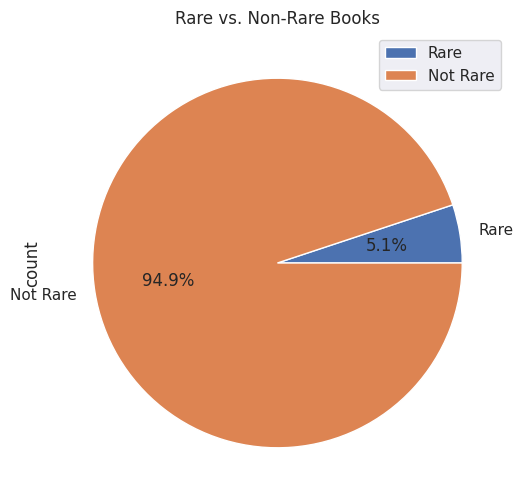

In [12]:
rare_books_query = """
SELECT
    CASE 
        WHEN NOT (
            json_extract(oclc_holdings, '$') IS NULL OR
            json_array_length(json_extract(oclc_holdings, '$')) = 0 OR
            json_contains(json_extract(oclc_holdings, '$'), '"many"')
        ) THEN 'Rare'
        ELSE 'Not Rare'
    END AS rarity,
    COUNT(*) AS count
FROM (
    SELECT json_extract(_source_file_unified_data, '$.classifications_unified.oclc_holdings') AS oclc_holdings 
    FROM read_parquet('/data/elasticsearchF/*.parquet')
)
GROUP BY rarity;
"""

df_rare = conn.execute(rare_books_query).fetchdf()
df_rare.plot.pie(y='count', labels=df_rare['rarity'], autopct='%1.1f%%', figsize=(6, 6), title="Rare vs. Non-Rare Books")


## 12. Number of Books by Decade

Count books by decade:

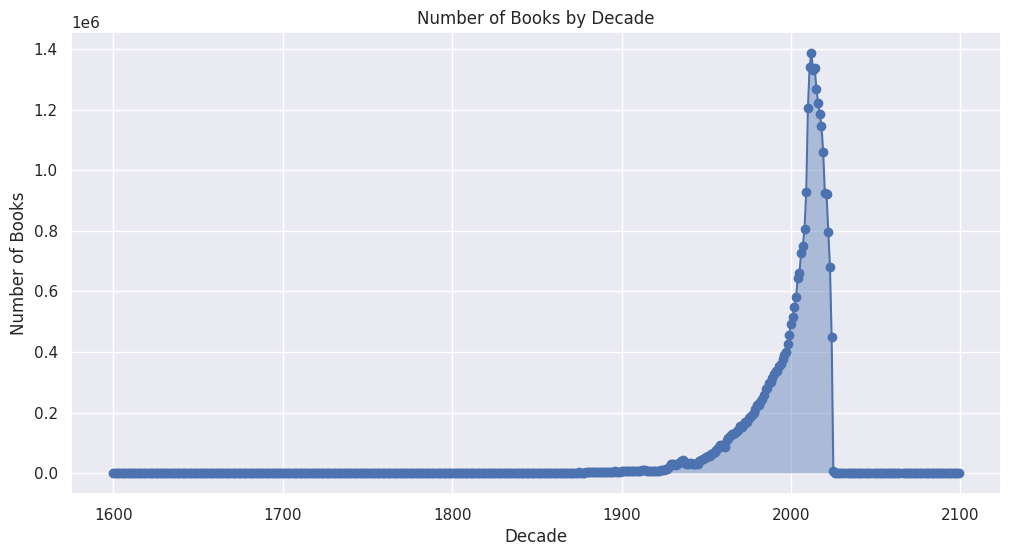

In [14]:
import matplotlib.pyplot as plt

books_by_decade_query = """
SELECT
    (publish_year / 10) * 10 AS decade,
    COUNT(*) AS count
FROM (
    SELECT
        TRY_CAST(_source_search_only_fields_search_year AS INTEGER) AS publish_year
    FROM read_parquet('/data/elasticsearchF/*.parquet')
    WHERE publish_year IS NOT NULL
)
GROUP BY decade
ORDER BY decade;
"""

df_decades = conn.execute(books_by_decade_query).fetchdf()

plt.figure(figsize=(12, 6))
plt.fill_between(df_decades["decade"], df_decades["count"], alpha=0.4)
plt.plot(df_decades["decade"], df_decades["count"], marker="o", linestyle="-")
plt.xlabel("Decade")
plt.ylabel("Number of Books")
plt.title("Number of Books by Decade")
plt.grid(True)
plt.show()


## 13. Edition Analysis

Analyzing edition variations:

In [15]:
edition_query = """
WITH edition_data AS (
    SELECT
        _source_file_unified_data_edition_varia_best AS main_edition,
        UNNEST(COALESCE(_source_file_unified_data_edition_varia_additional::VARCHAR[], ARRAY[]::VARCHAR[])) AS additional_edition
    FROM read_parquet('/data/elasticsearchF/*.parquet')
    WHERE _source_file_unified_data_edition_varia_best IS NOT NULL
)
SELECT
    main_edition,
    COUNT(DISTINCT additional_edition) AS edition_variations,
    LIST(DISTINCT additional_edition) AS variations
FROM edition_data
WHERE additional_edition IS NOT NULL
GROUP BY main_edition
HAVING edition_variations > 1
ORDER BY edition_variations DESC
LIMIT 10;
"""

df_editions = conn.execute(edition_query).fetchdf()
display(df_editions)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,main_edition,edition_variations,variations
0,2011,58890,"[""2006, 2022"", ""Hamburg, Germany, 2007"", ""1996..."
1,2012,51363,"[""1, FR, 2006"", ""London, 1999"", ""1. Aufl, Ersc..."
2,2013,47426,"[""The Incredible worlds of Wally McDoogle ;, D..."
3,2010,46504,"[""Los Gatos, California, USA, 2011"", ""Del Rey ..."
4,2014,45449,"[""2007"", ""1. Aufl, Erscheinungsort nicht ermit..."
5,"2006, 2006",38537,"[""Ta tong li shi wen hua cong shu, Tai yuan, 2..."
6,2015,37724,"[""1. Auflage, Berlin, 2016"", ""New York, 2014"",..."
7,"2005, 2005",37599,"[""Di 1ban, Beijing, China, 2005"", ""Varieties o..."
8,"2004, 2004",36753,"[""Di 1 ban, 北京 Beijing, 2005"", ""Guang ming shu..."
9,"2010, 2010",36204,"[""Di 1 ban, Yan ji, 2010"", ""Fu dan bo xue, fa ..."


## 14. AACID Analysis

Analyzing AACID patterns: The most complex query in this notebook

In [16]:
aacid_query = """
WITH aacid_patterns AS (
    SELECT
        UNNEST(COALESCE(_source_file_unified_data_identifiers_unified_aacid::VARCHAR[], ARRAY[]::VARCHAR[])) AS aacid,
        SPLIT_PART(aacid, '__', 2) AS source_type,
        SPLIT_PART(aacid, '__', 3) AS timestamp
    FROM read_parquet('/data/elasticsearchF/*.parquet')
    WHERE _source_file_unified_data_identifiers_unified_aacid IS NOT NULL
)
SELECT
    source_type,
    COUNT(*) AS count,
    MIN(timestamp) AS earliest_record,
    MAX(timestamp) AS latest_record
FROM aacid_patterns
WHERE source_type IS NOT NULL
GROUP BY source_type
ORDER BY count DESC;
"""

df_aacids = conn.execute(aacid_query).fetchdf()
display(df_aacids)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,source_type,count,earliest_record,latest_record
0,worldcat,135627739,20241230T203056Z,20241230T203056Z
1,duxiu_records,65695603,20240130T000000Z,20240305T000000Z
2,isbngrp_records,30692103,20240920T194930Z,20240920T194930Z
3,zlib3_records,21480271,20240809T171652Z,20250120T080202Z
4,gbooks_records,11954813,20240920T051416Z,20240920T051416Z
...,...,...,...,...
88,upload_records_cmpedu,4960,20240627T230528Z,20240627T230531Z
89,upload_files_ia_multipart,451,20241216T022308Z,20241216T022308Z
90,upload_records_ia_multipart,451,20241216T123526Z,20241223T193553Z
91,upload_files_woz9ts_duxiu,211,20240527T233501Z,20240527T233501Z


## 15. Books by language

Comparison of books by language

<Axes: title={'center': 'Books by Language'}, ylabel='count'>

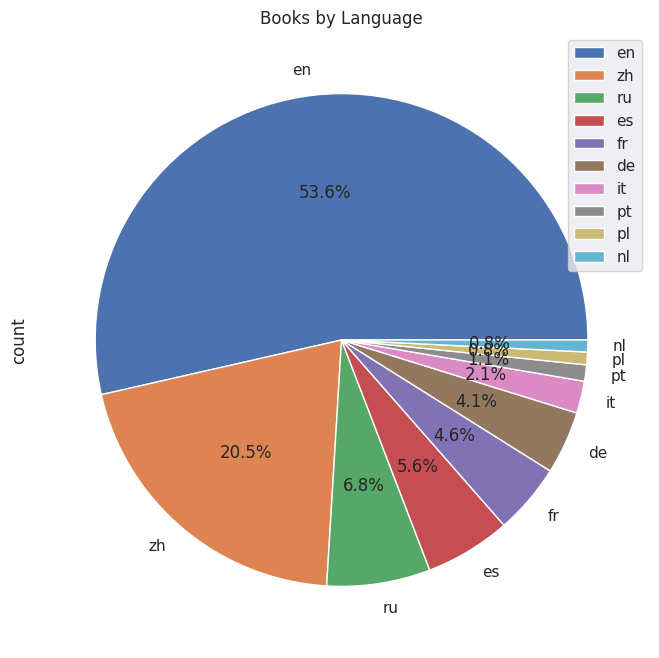

In [17]:
language_query = """
SELECT
    CASE 
        WHEN _source_file_unified_data_most_likely_language_codes LIKE '[%]' 
        THEN regexp_extract(_source_file_unified_data_most_likely_language_codes, '^\\["([^"]*)"', 1) 
        ELSE _source_file_unified_data_most_likely_language_codes 
    END AS language,
    COUNT(*) AS count
FROM read_parquet('/data/elasticsearchF/*.parquet')
WHERE _source_file_unified_data_most_likely_language_codes IS NOT NULL
  AND _source_file_unified_data_most_likely_language_codes != '[]'
GROUP BY language
ORDER BY count DESC
LIMIT 10;
"""

df_language = conn.execute(language_query).fetchdf()
df_language.plot.pie(y='count', labels=df_language['language'], autopct='%1.1f%%', figsize=(8, 8), title="Books by Language")

## 16. Search Text Analysis

Analyzing search text patterns:

In [18]:
search_text_query = """
WITH text_stats AS (
    SELECT
        _source_file_unified_data_content_type_best as content_type,
        LENGTH(_source_search_only_fields_search_text) as text_length
    FROM read_parquet('/data/elasticsearchF/*.parquet')
    WHERE _source_search_only_fields_search_text IS NOT NULL
      AND _source_file_unified_data_content_type_best IS NOT NULL
)
SELECT
    content_type,
    COUNT(*) as total_records,
    ROUND(AVG(text_length), 2) as avg_text_length,
    MIN(text_length) as min_length,
    MAX(text_length) as max_length
FROM text_stats
GROUP BY content_type
HAVING total_records > 100
ORDER BY avg_text_length DESC;
"""

import time
start_time = time.time()

df_search_text = conn.execute(search_text_query).fetchdf()
display(df_search_text)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,content_type,total_records,avg_text_length,min_length,max_length
0,book_nonfiction,6634241,8403.26,720,529022
1,other,69633,5977.97,1236,67209
2,book_unknown,23584279,5597.24,913,5125558
3,book_fiction,9311848,4206.27,803,95446
4,musical_score,489,3244.29,2953,6463
5,magazine,4535434,3073.03,798,48914
6,standards_document,999168,2160.02,1342,17197
7,book_comic,2724452,1908.29,1122,26636


## 17. Download Availability Analysis

Analyzing download options:

In [5]:
download_query = """
WITH extracted_data AS (
    SELECT
        _source_file_unified_data_content_type_best AS content_type,
        _source_file_unified_data_has_aa_downloads::INTEGER AS aa_downloads,
        _source_file_unified_data_has_aa_exclusive_downloads::INTEGER AS exclusive_downloads,
        _source_file_unified_data_has_torrent_paths::INTEGER AS torrent_available,
        _source_file_unified_data_has_scidb::INTEGER AS scidb_available
    FROM read_parquet('/data/elasticsearchF/*.parquet')
)
SELECT
    content_type,
    COUNT(*) AS total_records,
    COUNT(*) FILTER (WHERE aa_downloads = 1) AS aa_downloads,
    COUNT(*) FILTER (WHERE exclusive_downloads = 1) AS exclusive_downloads,
    COUNT(*) FILTER (WHERE torrent_available = 1) AS torrent_available,
    COUNT(*) FILTER (WHERE scidb_available = 1) AS scidb_available
FROM extracted_data
GROUP BY content_type
HAVING total_records > 100
ORDER BY total_records DESC;
"""

df_downloads = conn.execute(download_query).fetchdf()
display(df_downloads)


,content_type,total_records,aa_downloads,exclusive_downloads,torrent_available,scidb_available
0,book_unknown,23584279,22949561,22949561,22949561,0
1,book_fiction,9311848,9139960,3108118,7944936,0
2,book_nonfiction,6634241,6373796,1759344,6333992,0
3,magazine,4535434,4495864,3153994,4494347,0
4,book_comic,2724452,2724449,29841,2592523,0
5,standards_document,999168,998862,29,998862,0
6,other,69633,1,1,1,0
7,musical_score,489,489,489,489,0


## 18. Retrieve All Keys

Get All keys and Data types

In [10]:
# Query to get a single complete record
query = """
SELECT *
FROM read_parquet('/data/elasticsearchaux/metadata_aarecords_metadata__0_8219.parquet')
LIMIT 1
"""

# Execute the query
df_single_record = conn.execute(query).fetchdf()

# Count and display the number of columns
num_columns = len(df_single_record.columns)
print(f"Total number of columns: {num_columns}")

# Display all available columns
print("\nAvailable columns:")
print(df_single_record.columns.tolist())

# Display the complete record
print("\nComplete record data:")
display(df_single_record)

Total number of columns: 108

Available columns:
['_index', '_id', '_score', '_source_file_unified_data', '_source_file_unified_data_added_date_best', '_source_file_unified_data_added_date_unified', '_source_file_unified_data_added_date_unified_date_lgli_source', '_source_file_unified_data_added_date_unified_date_zlib_source', '_source_file_unified_data_author_additional', '_source_file_unified_data_author_best', '_source_file_unified_data_classifications_unified', '_source_file_unified_data_classifications_unified_collection', '_source_file_unified_data_classifications_unified_content_type', '_source_file_unified_data_classifications_unified_date_lgli_source', '_source_file_unified_data_classifications_unified_date_zlib_source', '_source_file_unified_data_classifications_unified_lang', '_source_file_unified_data_classifications_unified_torrent', '_source_file_unified_data_classifications_unified_year', '_source_file_unified_data_comments_multiple', '_source_file_unified_data_content_t

,_index,_id,_score,_source_file_unified_data,_source_file_unified_data_added_date_best,_source_file_unified_data_added_date_unified,_source_file_unified_data_added_date_unified_date_lgli_source,_source_file_unified_data_added_date_unified_date_zlib_source,_source_file_unified_data_author_additional,_source_file_unified_data_author_best,_source_file_unified_data_classifications_unified,_source_file_unified_data_classifications_unified_collection,_source_file_unified_data_classifications_unified_content_type,_source_file_unified_data_classifications_unified_date_lgli_source,_source_file_unified_data_classifications_unified_date_zlib_source,_source_file_unified_data_classifications_unified_lang,_source_file_unified_data_classifications_unified_torrent,_source_file_unified_data_classifications_unified_year,_source_file_unified_data_comments_multiple,_source_file_unified_data_content_type_best,_source_file_unified_data_cover_url_additional,_source_file_unified_data_cover_url_best,_source_file_unified_data_edition_varia_additional,_source_file_unified_data_edition_varia_best,_source_file_unified_data_extension_additional,_source_file_unified_data_extension_best,_source_file_unified_data_filesize_additional,_source_file_unified_data_filesize_best,_source_file_unified_data_has_aa_downloads,_source_file_unified_data_has_aa_exclusive_downloads,_source_file_unified_data_has_meaningful_problems,_source_file_unified_data_has_scidb,_source_file_unified_data_has_torrent_paths,_source_file_unified_data_identifiers_unified,_source_file_unified_data_identifiers_unified_aacid,_source_file_unified_data_identifiers_unified_aarecord_id,_source_file_unified_data_identifiers_unified_doi,_source_file_unified_data_identifiers_unified_filepath,_source_file_unified_data_identifiers_unified_issn,_source_file_unified_data_identifiers_unified_lgli,_source_file_unified_data_identifiers_unified_lgli_scimag_id,_source_file_unified_data_identifiers_unified_md5,_source_file_unified_data_identifiers_unified_server_path,_source_file_unified_data_identifiers_unified_zlib,_source_file_unified_data_ipfs_infos,_source_file_unified_data_language_codes,_source_file_unified_data_language_codes_detected,_source_file_unified_data_most_likely_language_codes,_source_file_unified_data_ol_is_primary_linked,_source_file_unified_data_original_filename_additional,_source_file_unified_data_original_filename_best,_source_file_unified_data_problems,_source_file_unified_data_publisher_additional,_source_file_unified_data_publisher_best,_source_file_unified_data_stripped_description_additional,_source_file_unified_data_stripped_description_best,_source_file_unified_data_title_additional,_source_file_unified_data_title_best,_source_file_unified_data_year_additional,_source_file_unified_data_year_best,_source_id,_source_indexes,_source_search_only_fields,_source_search_only_fields_search_access_types,_source_search_only_fields_search_added_date,_source_search_only_fields_search_author,_source_search_only_fields_search_bulk_torrents,_source_search_only_fields_search_content_type,_source_search_only_fields_search_description_comments,_source_search_only_fields_search_doi,_source_search_only_fields_search_edition_varia,_source_search_only_fields_search_extension,_source_search_only_fields_search_filesize,_source_search_only_fields_search_isbn13,_source_search_only_fields_search_most_likely_language_code,_source_search_only_fields_search_original_filename,_source_search_only_fields_search_publisher,_source_search_only_fields_search_record_sources,_source_search_only_fields_search_score_base_rank,_source_search_only_fields_search_text,_source_search_only_fields_search_title,_source_search_only_fields_search_year,_source_source_records,_source_source_records_0__source_record,_source_source_records_0__source_record_comics_id,_source_source_records_0__source_record_f_id,_source_source_records_0__source_record_fiction_id,_source_source_records_0__source_record_fiction_rus_id,_source_source_recor